This analysis is based on real estate data for personal properties, but some of the same techniques couold be used for industrial real estate

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
%matplotlib inline

In [2]:
df_train = pd.read_csv('data/train.csv')

In [36]:
# Here are the initial categories of the data
print("This dataset has information on {} different properties".format(len(df_train)))
print("The data contain the following information for each house: {}".format(df_train.columns))

This dataset has information on 1460 different properties
The data contain the following information for each house: Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageTy

In [37]:
# And here's what the categories look like
df_train.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


To me, it looks like YearBuilt, TotalBsmtSF, and GrLivArea are going to be the most important predictors, so we'll focus on those

Note for the time being, this doesn't look at location, which is want you want. But if we can remove the other variables, maybe all that's left will be location

In the end, SalePrice is what we're always trying to predict with these models, so let's look at that number

In [6]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

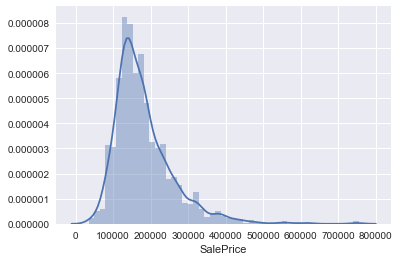

In [7]:
# And let's look at the distribution
sns.distplot(df_train['SalePrice'])

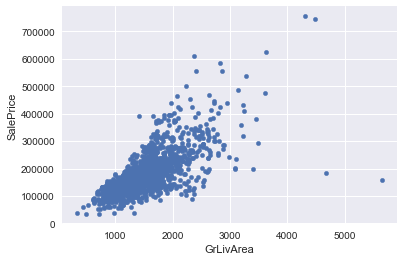

In [9]:
# Now let's look at GrLivArea versus sale price
var = 'GrLivArea'
price =  'SalePrice'
area_and_price = pd.concat([df_train['SalePrice'], df_train['GrLivArea']], axis=1)
area_and_price.plot.scatter(x='GrLivArea', y='SalePrice')

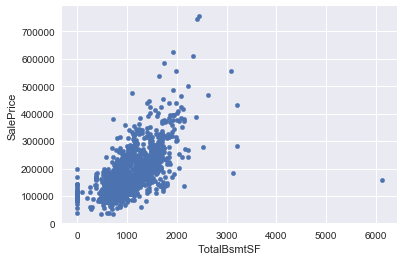

In [10]:
# Let's do the same for basement squarefeet
bsmnt_and_price = pd.concat([df_train['SalePrice'], df_train['TotalBsmtSF']], axis=1)
bsmnt_and_price.plot.scatter(x='TotalBsmtSF', y='SalePrice')

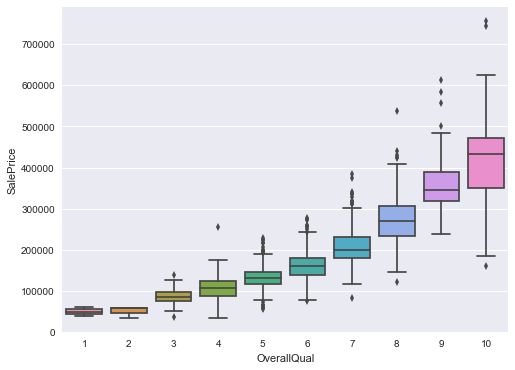

In [13]:
# There's also an overall quality metric in the data. Let's look at it now
var = 'OverallQual'
price =  'SalePrice'
qual_and_price = pd.concat([df_train[price], df_train[var]], axis=1)
fig, axis = plt.subplots(figsize=(8,6))
fig = sns.boxplot(x=var, y=price, data=qual_and_price)

In [14]:
# Clearly the price increases with overall quality, which is to be expected

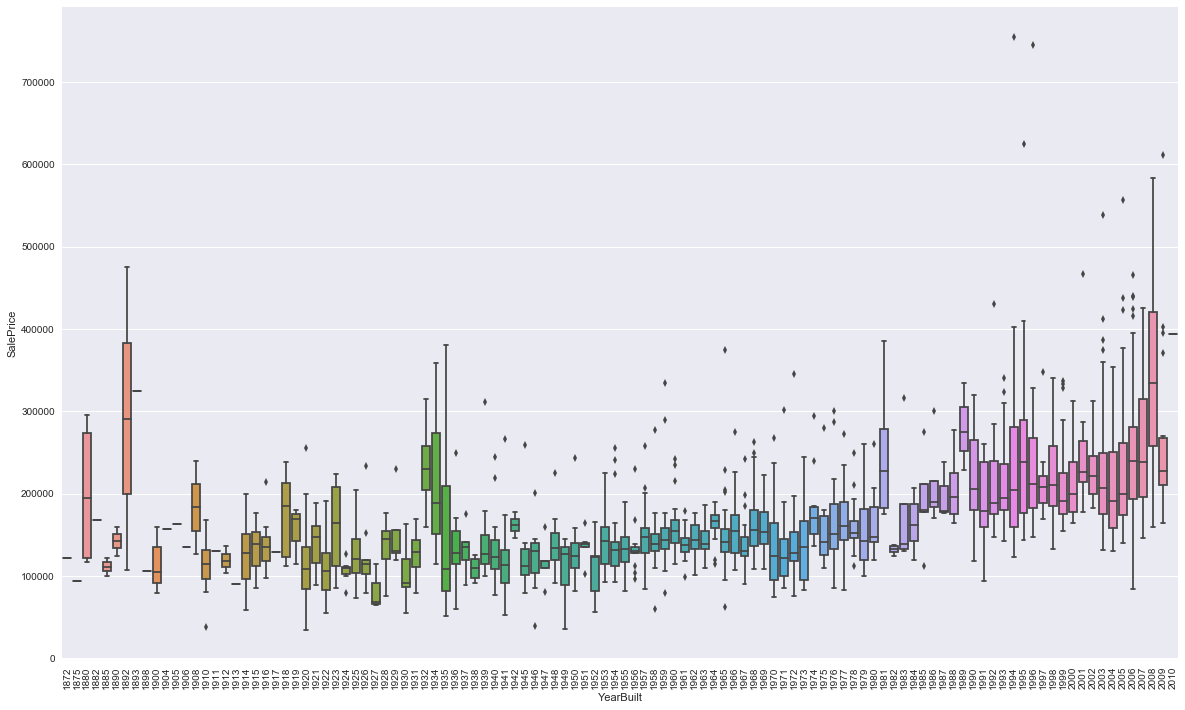

In [19]:
# And we can do the same thing with year built
var = 'YearBuilt'
year_and_price = pd.concat([df_train[price], df_train[var]], axis=1)
fig, axis = plt.subplots(figsize=(20,12))
fig = sns.boxplot(x=var, y=price, data=year_and_price)
plt.xticks(rotation=90);

In [20]:
# It looks like new stuff goes for more than old stuff, but the connection isn't particuarly strong

In [21]:
# OK, but we don't know what variables correlate the most with each other. Let's look at a heat map to find that.

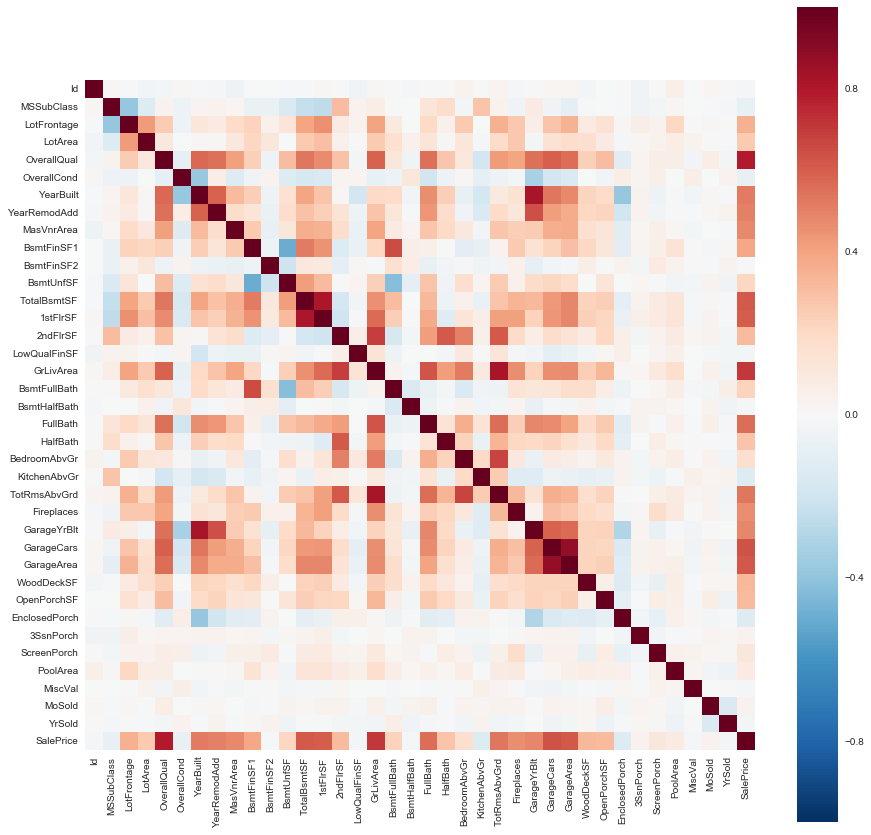

In [23]:
corr_matrix = df_train.corr()
f, ax = plt.subplots(figsize=(15,15))
sns.heatmap(corr_matrix, square=True)

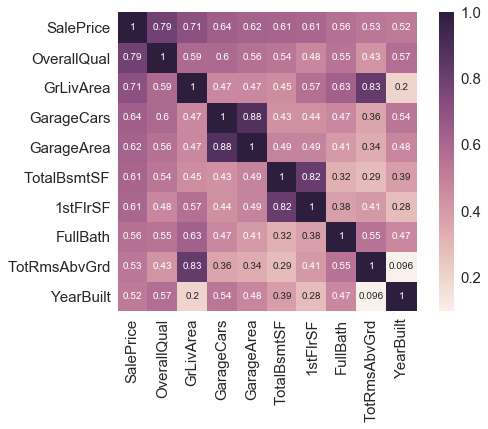

In [29]:
# OK, let's make another that just has the variables that are most closely correlated with sale price
k = 10
cols = corr_matrix.nlargest(k, price)[price].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, annot=True, square=True, annot_kws={'size':10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

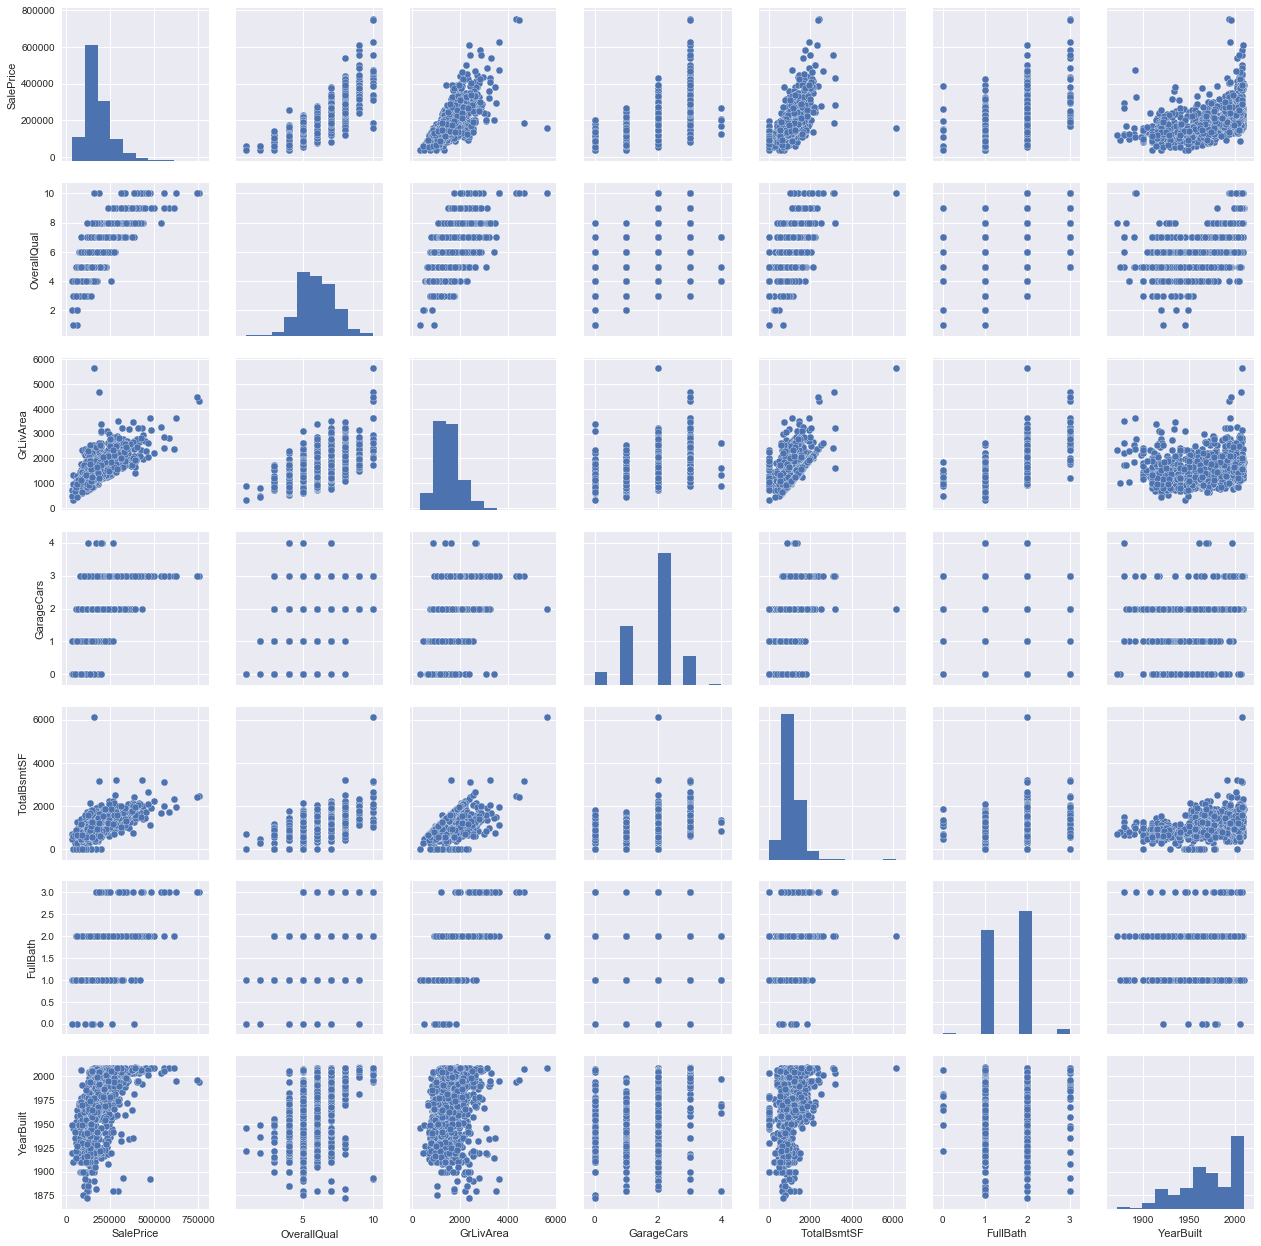

In [31]:
# It looks like the number of cars that can fit in the garage (GarageCars) is a strong variable. We'll have to look at that
# Let's look at the most important variables and how they correlate with one another
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], size = 2.5)
plt.show()